# 04 - Applied ML

In [1]:
from math import ceil

import seaborn as sns

import pandas as pd
import numpy as np
import scipy.stats as stats
from operator import itemgetter
from scipy.stats import kstest

from scipy.stats import pareto
from scipy.stats import powerlaw
from scipy.stats import rayleigh

from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

We load the dataframe, rename the race, married and nodegree variables to printable names and categorize them.

In [3]:
df = pd.read_csv('lalonde.csv', index_col=[0])

df['race'] = 'white'
df.loc[df['black'] == 1, 'race'] = 'black'
df.loc[df['hispan'] == 1, 'race'] = 'hispanic'
df.drop('black', 1, inplace=True)
df.drop('hispan', 1, inplace=True)
df['race'] = df['race'].astype('category')

df['married'] = df['married'].replace({0: 'Not married', 1: 'Married'}).astype('category')
df['nodegree'] = df['nodegree'].replace({0: 'Degree', 1: 'No degree'}).astype('category')

# Question 1

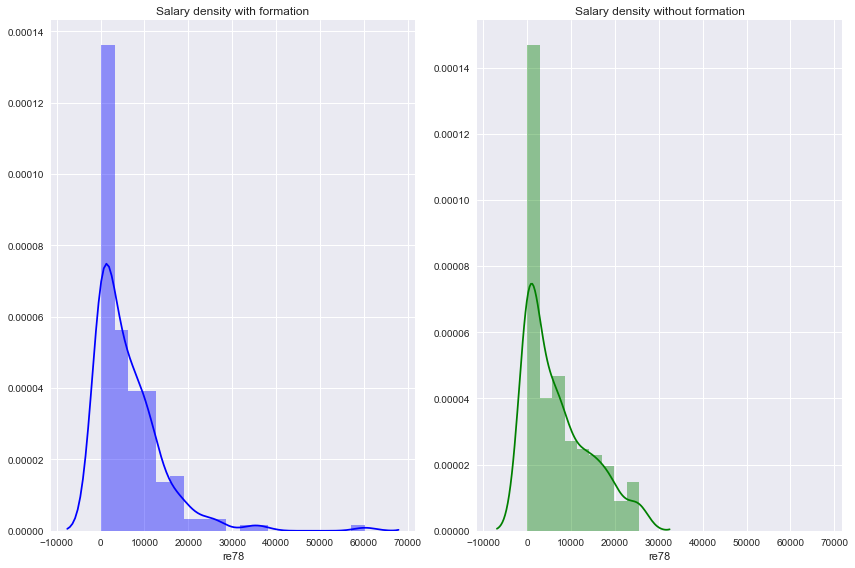

In [4]:
treated_res = df[df['treat'] == 1]['re78']
not_treated_res = df[df['treat'] == 0]['re78']

f, axes = plt.subplots(1, 2, figsize=(12, 8), sharex=True)
ax = axes[0]
ax.set_title("Salary density with formation")
sns.distplot(treated_res, color="b",  ax=ax);
ax = axes[1]
ax.set_title("Salary density without formation")
sns.distplot(not_treated_res, color="g", ax=ax);
plt.tight_layout()

Note about Kolmogorov-Smirnov test: even if very small difference, test will be zero, since test for exact match.
cf. https://stats.stackexchange.com/questions/74434/kolmogorov-smirnov-test-strange-output

I've tried with a lot of different distribution, and none gave me good results.

In [5]:
for n in range(1,5):
    for n2 in range(1, 5):
        print(stats.kstest(treated_res, 'f', [n,n2]))

KstestResult(statistic=0.72247061154971226, pvalue=0.0)
KstestResult(statistic=0.75332374053660534, pvalue=0.0)
KstestResult(statistic=0.75631520981296152, pvalue=0.0)
KstestResult(statistic=0.75668692399293636, pvalue=0.0)
KstestResult(statistic=0.71926741635058788, pvalue=0.0)
KstestResult(statistic=0.75331784777126587, pvalue=0.0)
KstestResult(statistic=0.75638722756771593, pvalue=0.0)
KstestResult(statistic=0.75670977605701406, pvalue=0.0)
KstestResult(statistic=0.71799512279017708, pvalue=0.0)
KstestResult(statistic=0.75331587751440088, pvalue=0.0)
KstestResult(statistic=0.75641475264985236, pvalue=0.0)
KstestResult(statistic=0.75671748675525574, pvalue=0.0)
KstestResult(statistic=0.71731828131037112, pvalue=0.0)
KstestResult(statistic=0.75331489125628437, pvalue=0.0)
KstestResult(statistic=0.7564293783315359, pvalue=0.0)
KstestResult(statistic=0.75672135980945399, pvalue=0.0)


QQplots for trying to match the distribution

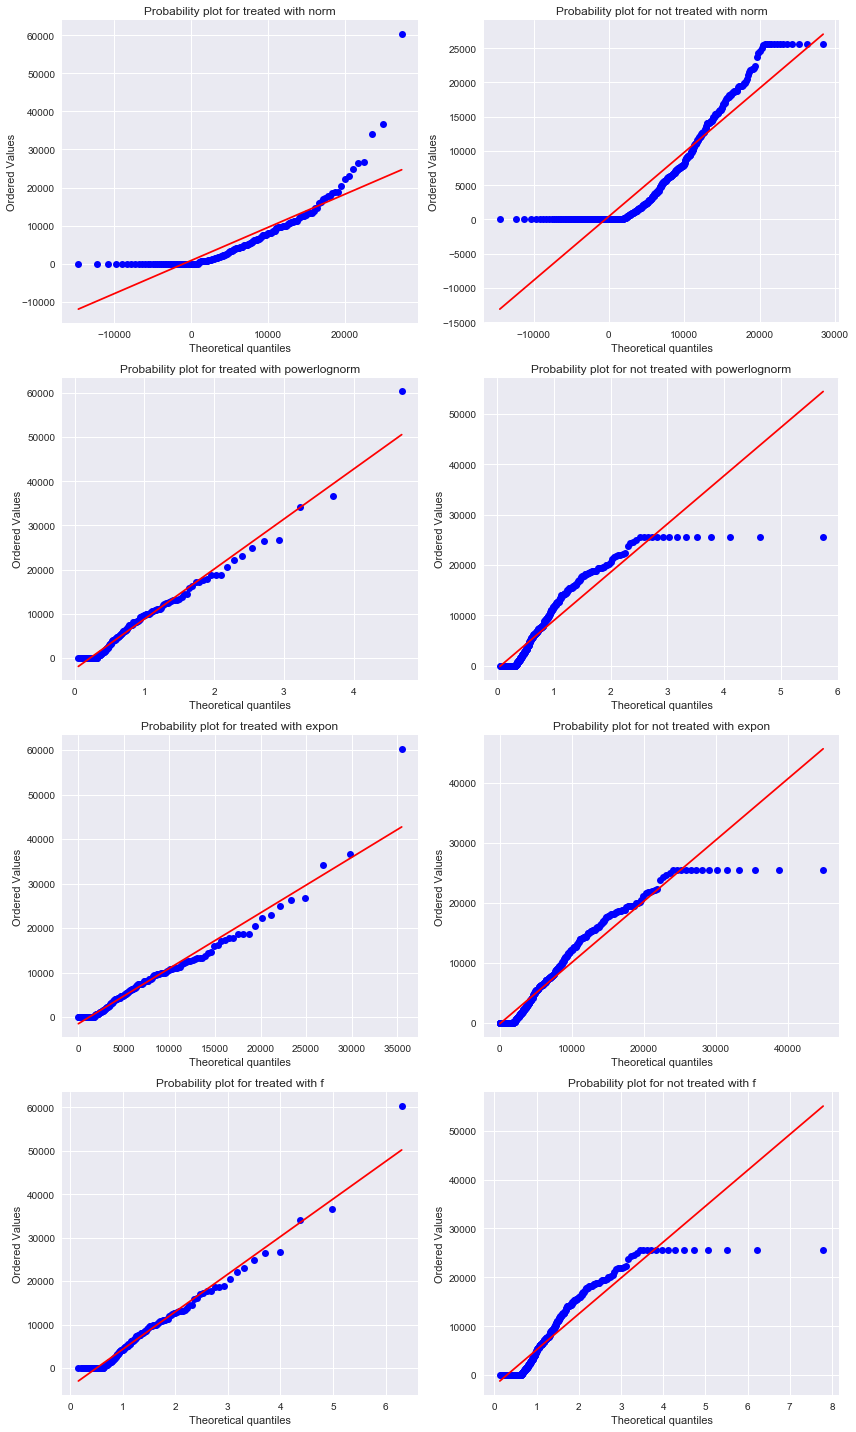

In [6]:
# dist_names = [ 'alpha', 'anglit', 'arcsine', 'beta', 'betaprime', 'bradford', 'burr', 'cauchy', 'chi', 'chi2', 'cosine', 'dgamma', 'dweibull', 'erlang', 'expon', 'exponweib', 'exponpow', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm', 'frechet_r', 'frechet_l', 'genlogistic', 'genpareto', 'genexpon', 'genextreme', 'gausshyper', 'gamma', 'gengamma', 'genhalflogistic', 'gilbrat', 'gompertz', 'gumbel_r', 'gumbel_l', 'halfcauchy', 'halflogistic', 'halfnorm', 'hypsecant', 'invgamma', 'invgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'ksone', 'kstwobign', 'laplace', 'logistic', 'loggamma', 'loglaplace', 'lognorm', 'lomax', 'maxwell', 'mielke', 'nakagami', 'ncx2', 'ncf', 'nct', 'norm', 'pareto', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rdist', 'reciprocal', 'rayleigh', 'rice', 'recipinvgauss', 'semicircular', 't', 'triang', 'truncexpon', 'truncnorm', 'tukeylambda', 'uniform', 'vonmises', 'wald', 'weibull_min', 'weibull_max', 'wrapcauchy'] 
dist_names = ['norm', 'powerlognorm', 'expon', 'f']
params_treated = [stats.norm.fit(treated_res), [2, 1], stats.expon.fit(treated_res), [10,10]]
params_not_treated = [stats.norm.fit(not_treated_res), [2, 1], stats.expon.fit(not_treated_res), [10,10]]
# results = []

# for dist in dist_names:
#     res = kstest(not_treated_res, dist, getattr(stats, dist).fit(not_treated_res))
#     results.append((dist, res[1]))
# max(results, key=itemgetter(1))
f, axes = plt.subplots(len(dist_names), 2, figsize=(12, len(dist_names)*5))

for idx, dist in enumerate(dist_names):
    ax = axes[idx, 0]
    stats.probplot(treated_res, dist=dist, sparams=params_treated[idx], plot=ax)
    ax.set_title("Probability plot for treated with " + dist)
    ax = axes[idx, 1]
    stats.probplot(not_treated_res, dist=dist, sparams=params_not_treated[idx], plot=ax)
#   stats.probplot(treated_res, dist=dist, sparams=getattr(stats, dist).fit(treated_res), plot=ax)
    ax.set_title("Probability plot for not treated with " + dist)
plt.tight_layout()

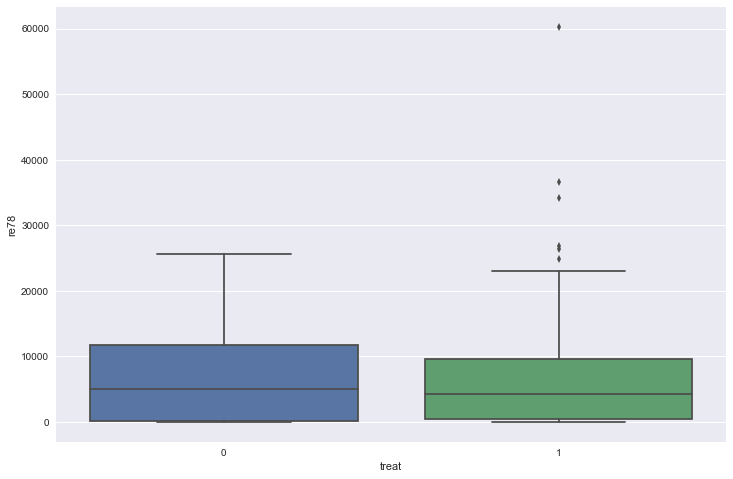

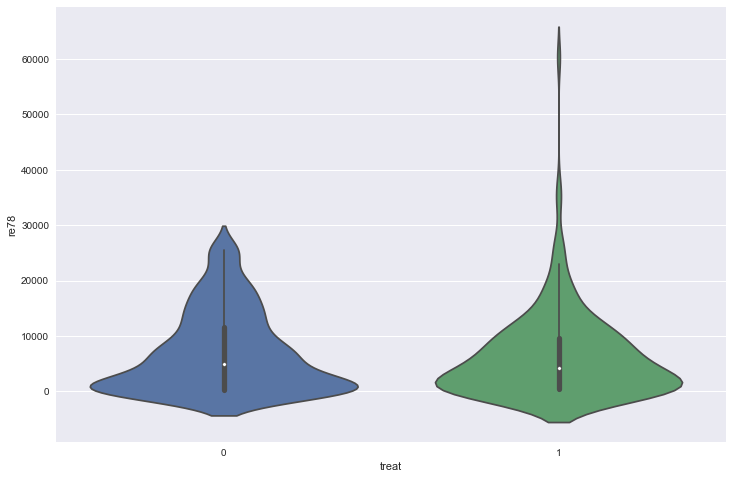

In [7]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(y='re78',x='treat', data=df, ax=ax);
fig, ax = plt.subplots(figsize=(12,8))
sns.violinplot(y='re78',x='treat', data=df, ax=ax);

In [8]:
print("Treated salary stats:\n" + treated_res.describe().to_string())
print("\nNot treated salary stats:\n" + not_treated_res.describe().to_string())

Treated salary stats:
count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000

Not treated salary stats:
count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000


Mean similar, quantile a bit lower, max much lower

# 2

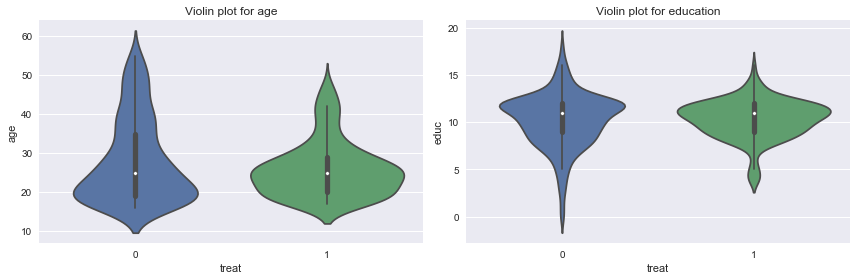

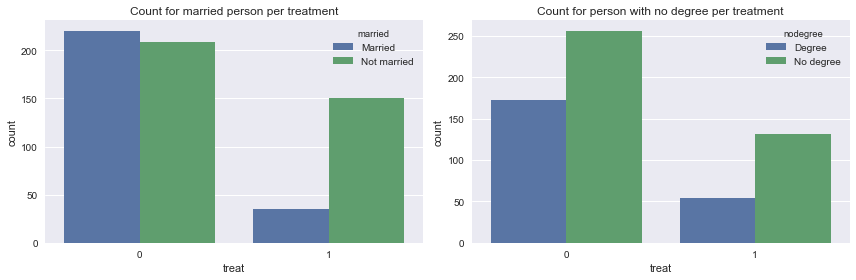

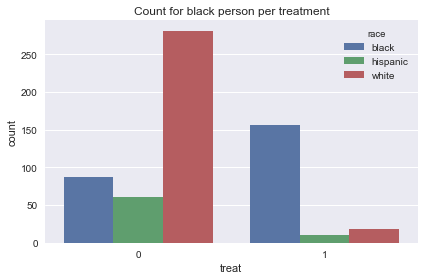

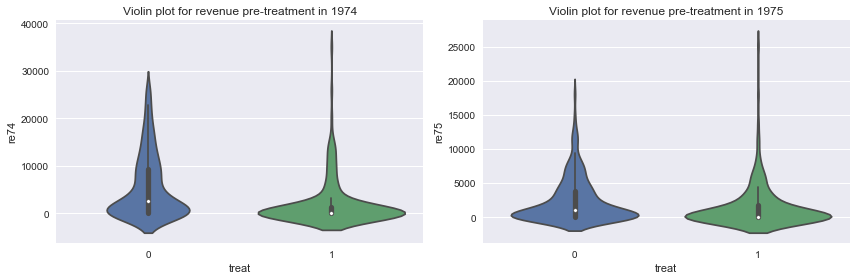

In [9]:
fig, axes = plt.subplots(1,2,figsize=(12,4))

axes[0].set_title("Violin plot for age")
sns.violinplot(x='treat', y='age', data=df, ax=axes[0])
axes[1].set_title("Violin plot for education")
sns.violinplot(x='treat', y='educ', data=df, ax=axes[1])
plt.tight_layout()

fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].set_title("Count for married person per treatment")
sns.countplot(x='treat',hue='married', data=df, ax=axes[0])
axes[1].set_title("Count for person with no degree per treatment")
sns.countplot(x='treat',hue='nodegree', data=df, ax=axes[1])
plt.tight_layout()

fig, axes = plt.subplots(1,1,figsize=(6,4))
axes.set_title("Count for black person per treatment")
sns.countplot(x='treat',hue='race', data=df, ax=axes)
plt.tight_layout()

fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].set_title("Violin plot for revenue pre-treatment in 1974")
sns.violinplot(x='treat', y='re74', data=df, ax=axes[0])
axes[1].set_title("Violin plot for revenue pre-treatment in 1975")
sns.violinplot(x='treat', y='re75', data=df, ax=axes[1])
plt.tight_layout();

# 3

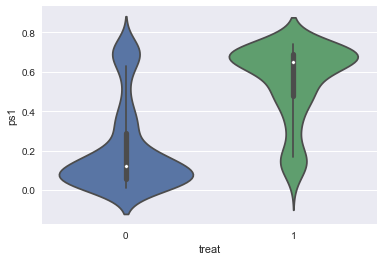

In [10]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
def compute_propensity(data):
    x = pd.get_dummies(data, columns=['race', 'married', 'nodegree']).drop(['treat', 're78'], 1)
    y = data['treat']
    logistic.fit(x,y)
    return logistic.predict_proba(x)[:,1]

propensity = compute_propensity(df)
df_copy = df.copy()
df_copy['ps1'] = propensity
sns.violinplot(x='treat', y='ps1', data=df_copy);

Definitly not well balanced...

# 4

Basic idea: 
Create a graph, where each person is a node, then add an edge between each person from treat and not-treat group which has for weight the absolute difference of propensity.

Then we simply need to apply a min weight matching alorithm on this graph to get the best pairs. Since networkx does not offer a max weight matching, we simply reversed the sign of the weight to get the min weight.


In [11]:
import networkx as nx

propensity = compute_propensity(df)

G = nx.Graph()
data_copy = df.copy()
propensity = pd.Series(propensity, index=data_copy.index)
treated = propensity[df['treat'] == 1]
not_treated = propensity[df['treat'] == 0]

for index_treated, ps_treated in treated.iteritems():
    for index_not_treated, ps_not_treated in not_treated.iteritems():
        propensity_diff = -np.abs(ps_treated - ps_not_treated)
        G.add_edge(index_treated, index_not_treated, weight=propensity_diff)

In [12]:
mate = nx.max_weight_matching(G, True)

In [13]:
matched = df.loc[mate.keys()]

In [14]:
propensity = compute_propensity(df)
data_copy = df.copy()
propensity = pd.Series(propensity, index=data_copy.index)

sum_ = 0
for k, v in mate2.items():
    sum_ += np.abs(propensity.loc[k]-propensity.loc[v])
sum_

NameError: name 'mate2' is not defined

Other implementation, works better, I do not know why...

We use for a caliper 0.2 * std(logit(propensity)) as suggested in https://www.ncbi.nlm.nih.gov/pubmed/20925139
for algorithm cf. http://onlinelibrary.wiley.com/doi/10.1002/sim.6004/epdf, we implemented greedy nearest neighbor (random) without replacement

In [ ]:
from scipy.special import logit
from sklearn.utils import shuffle

def match(data, propensity, seed=1):
    np.random.seed(seed)
    
    caliper = 0.2 * logit(propensity).std()
    data_internal = data.copy()
    data_internal['propensity'] = propensity
    treated = data_internal[data_internal['treat'] == 1]
    not_treated = data_internal[data_internal['treat'] == 0]
    
    matched = treated.copy()
    for idx, propensity in treated['propensity'].iteritems():
        distance = (propensity - not_treated['propensity']).abs()
        print(idx, distance)
        min_index = distance.argmin()
        min_dist = distance.loc[min_index]
        if min_dist < caliper:
            matched.loc[len(matched)] = not_treated.loc[min_index]
            not_treated.drop(min_index)
        else:
            print("No Match")
    return matched

In [ ]:
propensity = compute_propensity(df)
matched = match(df, propensity)
propensity = compute_propensity(matched)
matched['ps1'] = propensity
sns.violinplot(x='treat', y='ps1', data=matched);

Much better, median closer, shape closer

In [ ]:
treated_res = matched[matched['treat'] == 1]['re78']
not_treated_res = matched[matched['treat'] == 0]['re78']

f, axes = plt.subplots(1, 2, figsize=(12, 8), sharex=True)
ax = axes[0]
ax.set_title("Salary density with formation")
sns.distplot(treated_res, color="b",  ax=ax);
ax = axes[1]
ax.set_title("Salary density without formation")
sns.distplot(not_treated_res, color="g", ax=ax);
plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(12,4))

axes[0].set_title("Violin plot for age")
sns.violinplot(x='treat', y='age', data=matched, ax=axes[0])
axes[1].set_title("Violin plot for education")
sns.violinplot(x='treat', y='educ', data=matched, ax=axes[1])
plt.tight_layout()

fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].set_title("Count for married person per treatment")
sns.countplot(x='treat',hue='married', data=matched, ax=axes[0])
axes[1].set_title("Count for person with no degree per treatment")
sns.countplot(x='treat',hue='nodegree', data=matched, ax=axes[1])
plt.tight_layout()

fig, axes = plt.subplots(1,1,figsize=(6,4))
axes.set_title("Count for black person per treatment")
sns.countplot(x='treat',hue='race', data=matched, ax=axes)
plt.tight_layout()

fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].set_title("Violin plot for revenue pre-treatment in 1974")
sns.violinplot(x='treat', y='re74', data=matched, ax=axes[0])
axes[1].set_title("Violin plot for revenue pre-treatment in 1975")
sns.violinplot(x='treat', y='re75', data=matched, ax=axes[1])
plt.tight_layout();

# Question 2

## Part 1
First of all we fetch the dataset.

In [2]:
newsgroups = fetch_20newsgroups(subset='all', data_home="./")

We begin by compute the tf-idf for the entire corpus. It will create a matrix of the form "number of posts" x "number of words in the whole corpus". We make use of the stop words included in the scikit-learn to remove them, as they do not give information about a certain post category.

In [358]:
vectorizer = TfidfVectorizer(stop_words='english')
data_tf_idf = vectorizer.fit_transform(newsgroups.data)

Then we partition the dataset in train, validation and test subsets. For the train set set we take the first 10% of the dataset, for the validation set we take the second 10% and for the test test set all that's left. This approach assumes that the dataset stores data in no particular order. If the data were ordered then splitting the data this way wouldn't be acceptable since we'd train the model on a specific category and then test it on another which would lead to poor performance. We printed and analyzed the data contained in newsgroups.data  and could remark that there's no relation of order between an element and the following one in the dataset.

In [359]:
data_size = newsgroups.target.shape[0]
train_size = ceil(data_size/10)
validation_size = train_size
test_size = data_size - train_size - validation_size

x_train = data_tf_idf[:train_size]
y_train = newsgroups.target[:train_size]

x_validation = data_tf_idf[train_size:2*train_size]
y_validation = newsgroups.target[train_size:2*train_size]

x_test = data_tf_idf[2*train_size:]
y_test = newsgroups.target[2*train_size:]

Now we need to train a random forest. First we use the validation test to do a grid search on the "max_depth" and "n_estimators" parameters to determine which values give the best results.

An exhaustive grid search would take a very long time, therefore we don't iterate on continuous subsets but we sample values in the range [1,41] with step 5 for "max_depth" and in the range [1,1001] with step 100 for "n_estimators". We chose large ranges in order to try capturing the behaviour of the parameters.

After the completion of the grid search we initialize a random forest with the parameters which produced best results in the grid search, and then train and test the random forest by using the corresponding sets.

In [390]:
seed = 1
depths = range(1, 42, 5)
n_estimators= range(1, 1002, 100)

best_prediction_score = 0
best_depth = -1
best_n_estimators = -1

for depth in depths:
    for n_estimator in n_estimators:
        clf = RandomForestClassifier(max_depth= None, n_estimators= n_estimator, random_state=seed, n_jobs = -1)
        clf.fit(x_train, y_train)
        predictions_validation = clf.predict(x_validation)
        prediction_score = metrics.accuracy_score(y_validation, predictions_validation)
        if prediction_score > best_prediction_score:
            best_prediction_score = prediction_score
            best_depth = depth
            best_n_estimators = n_estimator
            
print(best_depth, best_n_estimators, best_prediction_score)

1 1001 0.757559681698


In [392]:
clf = RandomForestClassifier(max_depth=None, n_estimators=best_n_estimators, random_state=seed, n_jobs = -1)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)

print(metrics.accuracy_score(y_test, predictions))

0.769700185726


Finally, we plot the confusion matrix associated to the random forest's predictions.

Please note that in order to compute the accuracy of the predictions and the confusion matrix we use methods of sklearn's metrics module. The manual implementation of these two methods would have been pretty straightforward therefore we think this choice doesn't impact negatively the learning process of the Machine Learning pipeline.

We went passed the actual newsgroup labels to the heatmap to make it more readable.

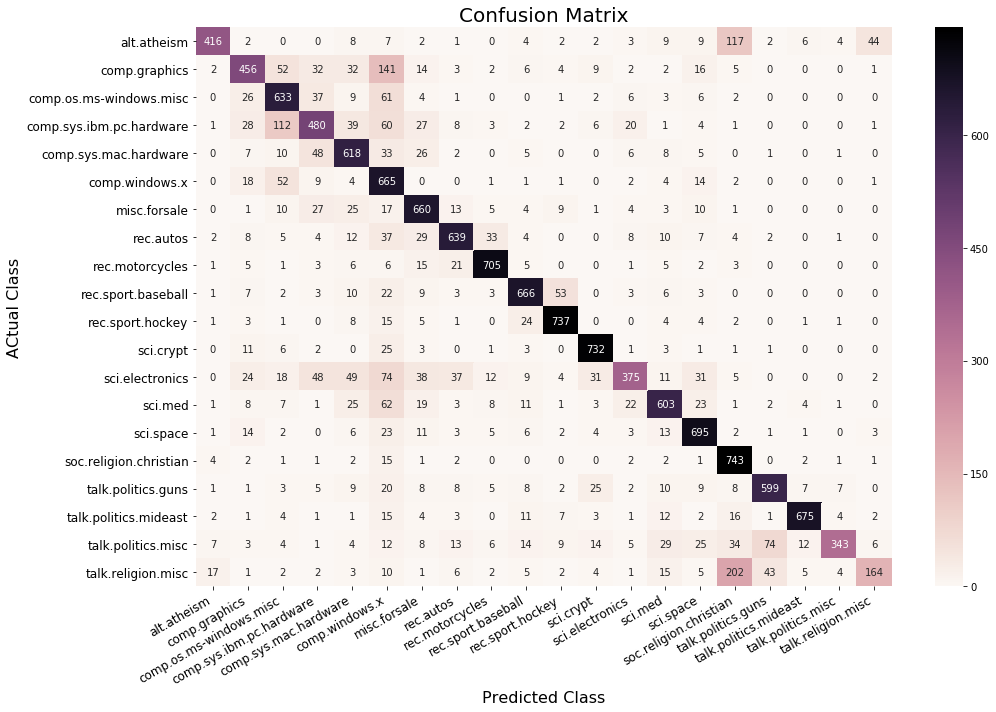

In [393]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions)

fig, ax = plt.subplots(figsize=(15,10))
plt.title("Confusion Matrix", fontsize=20)
sns.heatmap(confusion_matrix, xticklabels=newsgroups.target_names, yticklabels=newsgroups.target_names, ax=ax, annot=True, fmt="d", cmap=sns.cubehelix_palette(dark=0, light=0.97, as_cmap=True))
ax.set_xlabel("Predicted Class", fontsize=16)
ax.set_ylabel("ACtual Class", fontsize=16)
ax.tick_params(labelsize=12)
fig.autofmt_xdate()
plt.tight_layout();

This confusion matrix shows how the the model produces mostly correct predictions, since we have high values on the diagonal and lower values elsewhere.
We can see that there is some confusion amongst posts related to the macro-category "comp", which makes sense.

Also we can see that sci.electronics posts are often confused with some articles of "comp".

Finally, the most significative confusion are the following:
- The posts talking about misc. religion are very often confused for posts about christian religion, which makes sense
- Posts about atheism are often mistaken for posts about christianism, which makes sense, but it is quite a bad confusion, since people wanting to read religious posts may not want to see atheist posts...
- Finally, there is some confusion for misc. political posts with posts about politics and guns, this confusion is not very "bad".


### Word importance analysis
Note that when we speak of feature, we actually speak of words.

We first compute the percentage of features that have a non-zero importance.

In [394]:
num_features = len(clf.feature_importances_)
non_zero =  clf.feature_importances_[clf.feature_importances_ != 0]
print("There is %.2f%% of features that are non-zero"%(len(non_zero)/num_features*100))

There is 20.64% of features that are non-zero


There is around 21% of the features that are non-zero, this means that the rest of the features have no importance to help determining the class of the post.

For example, if a word is only appearing in one post, it will have zero value in all other posts. This criteria will certainly not be selected for a tree decision, since it only helps with a single post. Another possibility would be to have a word that appears in every post with a similar tf-idf, this word would not help us choose a category, thus it will certainly not be selected by the algorithm.

We begin by plotting the raw importances of feature.

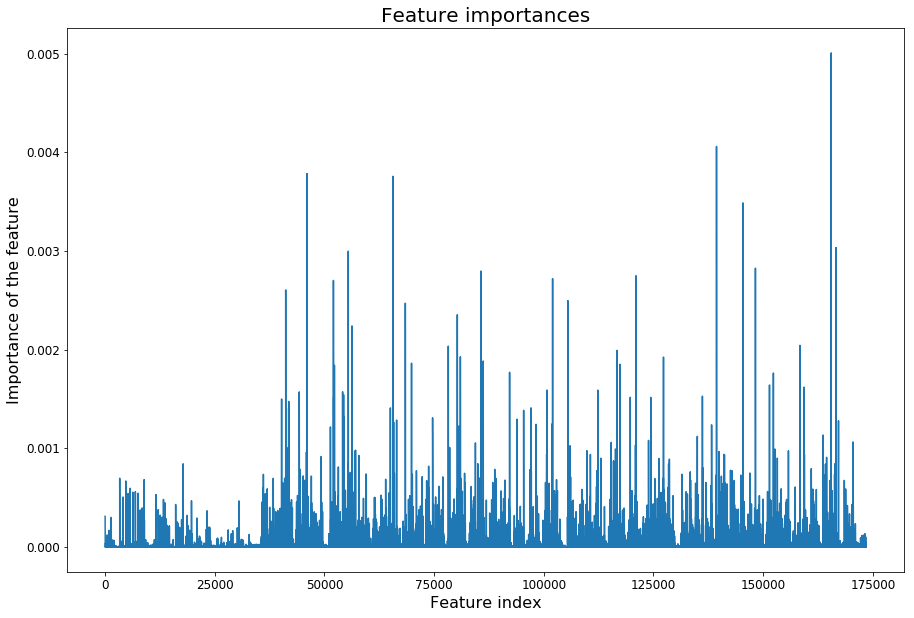

In [395]:
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(clf.feature_importances_)
plt.title("Feature importances", fontsize=20)
ax.set_xlabel("Feature index", fontsize=16)
ax.set_ylabel("Importance of the feature", fontsize=16)
ax.tick_params(labelsize=12);

From this raw graph, we can already see that a few features make up for most of the importance. Thus these features are the one that help categorizing the most a particular post.

We will now plot the cumulative importance of the features. Note that we used a logarithmic scale for the x-axis, this will help visualize the gain if we add an order of magnitude of features.

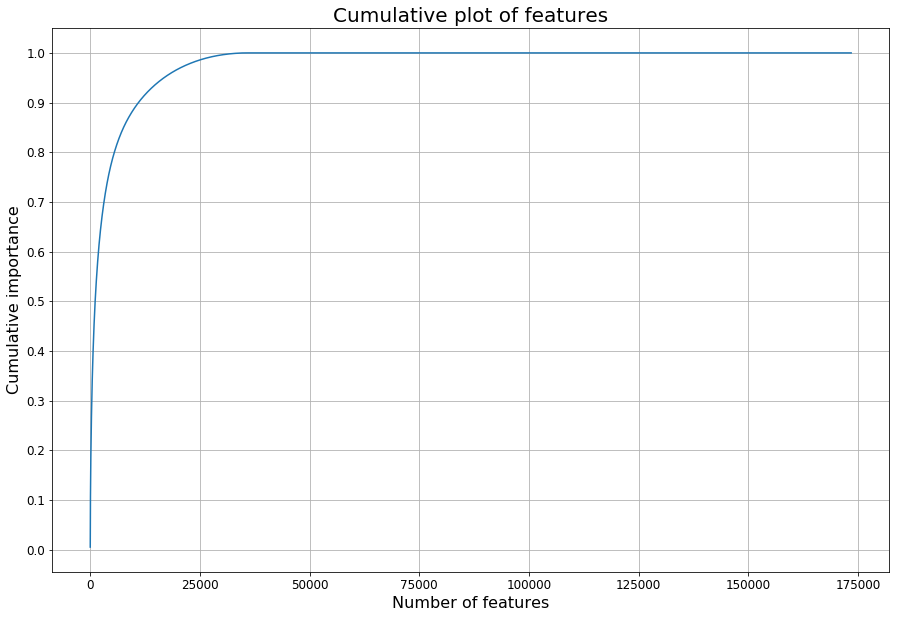

In [391]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(np.cumsum(sorted(clf.feature_importances_, reverse=True)))
ax.grid(True);
plt.title("Cumulative plot of features", fontsize=20)
ax.yaxis.set_ticks(np.arange(0, 1.1, 0.1))
ax.set_xlabel("Number of features", fontsize=16)
ax.set_ylabel("Cumulative importance", fontsize=16)
ax.tick_params(labelsize=12);

We see that the cumulative importance grows nearly linearily with the order of magnitude of added features. This means that the first few features are the most significant one. We'll proceed to print the names of these features to gain some insight on their nature. We sort the features by importance and print the top 20 words.

In [400]:
top20 = clf.feature_importances_.argsort()[-20:][::-1]
print(("\n".join(np.array(vectorizer.get_feature_names())[top20])))

windows
sale
bike
dod
space
writes
clipper
subject
hockey
organization
lines
car
article
mac
edu
god
com
university
game
nhl


The most important features are indeed terms that allow the model to efficiently disambiguate among categories. 
For instance if the term "windows" appears in a text, then most likely it'll be part of category "comp.os.ms-windows" or "comp.windows.x". "sale" is associated to category "misc.forsale, "bike" to category "rec.motorcycle" and so on.